<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parking-tickets-in-Toronto" data-toc-modified-id="Parking-tickets-in-Toronto-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parking tickets in Toronto</a></span><ul class="toc-item"><li><span><a href="#Read-and-preprocess-2019-2020-data" data-toc-modified-id="Read-and-preprocess-2019-2020-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read and preprocess 2019-2020 data</a></span></li></ul></li><li><span><a href="#Exploration-from-time-perspective" data-toc-modified-id="Exploration-from-time-perspective-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploration from time perspective</a></span><ul class="toc-item"><li><span><a href="#Year-exploration" data-toc-modified-id="Year-exploration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Year exploration</a></span></li><li><span><a href="#Breakdown-to-top-infractions" data-toc-modified-id="Breakdown-to-top-infractions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Breakdown to top infractions</a></span></li></ul></li><li><span><a href="#Exploration-from-location(map)-perspective" data-toc-modified-id="Exploration-from-location(map)-perspective-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploration from location(map) perspective</a></span><ul class="toc-item"><li><span><a href="#Top-streets-and-locations" data-toc-modified-id="Top-streets-and-locations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Top streets and locations</a></span></li><li><span><a href="#Association-rules-mining" data-toc-modified-id="Association-rules-mining-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Association rules mining</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import altair as alt
import os
sns.set(style="darkgrid")

from statsmodels.tsa.seasonal import seasonal_decompose

## Parking tickets in Toronto

### Read and preprocess 2019-2020 data

In [2]:
csv = pd.read_csv(f'./data/Parking_Tags_Data_2019.003.csv',nrows=100)
csv.head().T

,0,1,2,3,4
tag_number_masked,***60285,***23812,***23813,***56412,***24234
date_of_infraction,20190511,20190511,20190511,20190511,20190511
infraction_code,406,3,3,337,5
infraction_description,PARK-VEH. W/O VALID ONT PLATE,PARK ON PRIVATE PROPERTY,PARK ON PRIVATE PROPERTY,PARK - ON BOULEVARD,PARK-SIGNED HWY-PROHIBIT DY/TM
set_fine_amount,40,30,30,50,50
time_of_infraction,702,704,705,706,706
location1,NR,NaN,NaN,NR,NR
location2,32 OLD MILL DR,220 EGLINTON AVE E,220 EGLINTON AVE E,34 BROOKLAWN AVE,52 AUSTIN TER
location3,NaN,NaN,NaN,NaN,NaN
location4,NaN,NaN,NaN,NaN,NaN


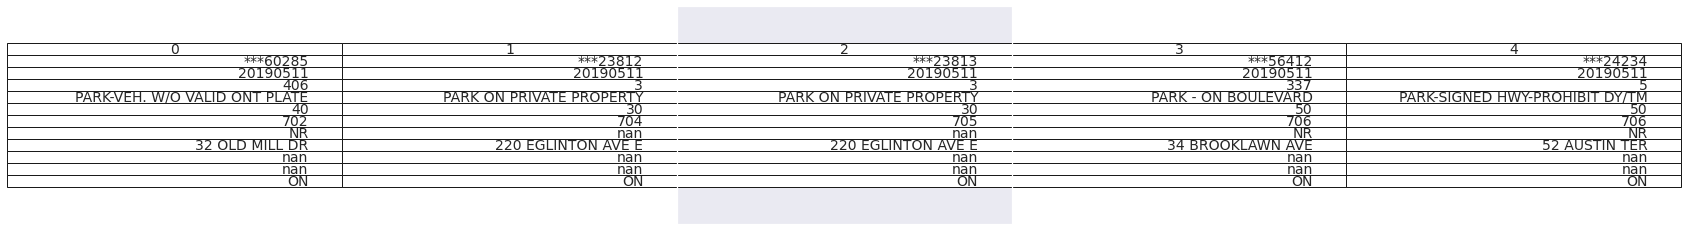

In [18]:
table = csv.head(5).T
cell_text = []
for row in range(len(table)):
    cell_text.append(table.iloc[row])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
a = ax.table(cellText=cell_text, colLabels=table.columns, loc='center')
a.set_fontsize(14)
a.scale(5,1)
# plt.tight_layout()
plt.show()

In [19]:
dfs = []
for file in os.listdir('./data'):    
    if file.lower().find('.csv')>0:
        print(f'processing {file}')        
        csv = pd.read_csv(f'./data/{file}',
            usecols=['date_of_infraction','infraction_description','time_of_infraction','location1','location2','location3','location4'])
        dfs.append(csv)
    
raw_df = pd.concat(dfs,copy=False).reset_index(drop=True)

processing Parking_Tags_Data_2020.002.csv
processing Parking_Tags_Data_2019.006.csv
processing Parking_Tags_Data_2020.001.csv
processing Parking_Tags_Data_2019.000.csv
processing Parking_Tags_Data_2019.005.csv
processing Parking_Tags_Data_2020.005.csv
processing Parking_Tags_Data_2020.003.csv
processing Parking_Tags_Data_2019.008.csv
processing Parking_Tags_Data_2019.002.csv
processing Parking_Tags_Data_2019.003.csv
processing Parking_Tags_Data_2020.000.csv
processing Parking_Tags_Data_2019.004.csv
processing Parking_Tags_Data_2019.001.csv
processing Parking_Tags_Data_2019.007.csv
processing Parking_Tags_Data_2020.004.csv


<AxesSubplot:>

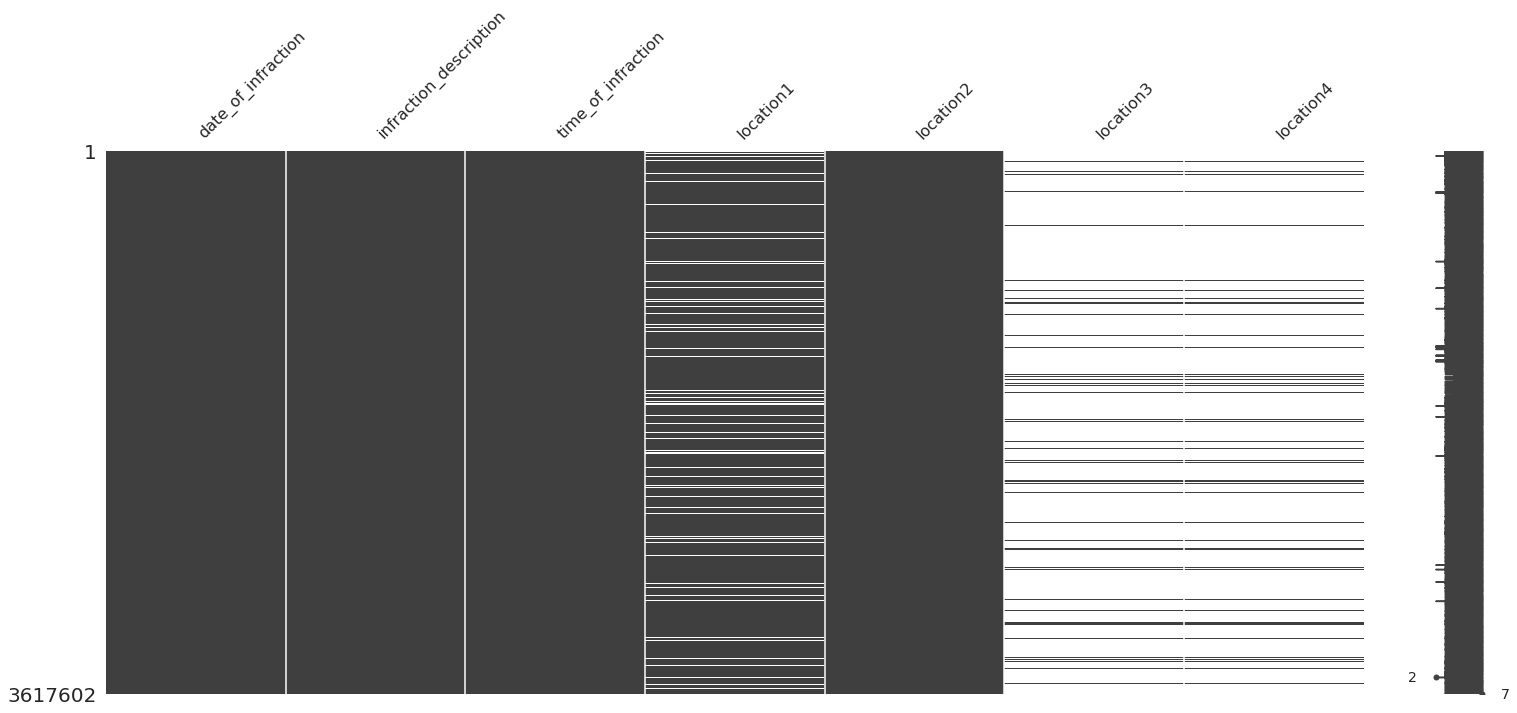

In [20]:
import missingno as msno
msno.matrix(raw_df)     

In [21]:
raw_df.isna().sum(axis=0)

date_of_infraction              0
infraction_description          0
time_of_infraction           3236
location1                  409062
location2                     293
location3                 3358713
location4                 3357918
dtype: int64

In [22]:
df = (raw_df.assign(
        time_str= lambda x: x['time_of_infraction'].fillna(2500).astype(int).astype(str).str.pad(4, side='left', fillchar='0'))
      .assign(
        date = lambda x: pd.to_datetime(x['date_of_infraction'].astype(str)+x['time_str'],errors='coerce'))
      .drop(['time_str','date_of_infraction','time_of_infraction',],axis=1)
      .rename({'infraction_description':'infraction'},axis=1))

print(f"data with missing/wrong time info {df['date'].isna().sum()}")
df = df[df['date'].notna()]

data with missing/wrong time info 3260


In [23]:
df['date'].min(),df['date'].max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2020-12-31 23:51:00'))

In [24]:
df['infraction'].value_counts().describe()

count       201.000000
mean      17981.800995
std       84788.619565
min           1.000000
25%           3.000000
50%          46.000000
75%        1333.000000
max      791971.000000
Name: infraction, dtype: float64

In [25]:
df['infraction'].value_counts().head(10)

PARK ON PRIVATE PROPERTY          791971
PARK-SIGNED HWY-PROHIBIT DY/TM    539183
PARK MACHINE-REQD FEE NOT PAID    501612
PARK PROHIBITED TIME NO PERMIT    442326
PARK - LONGER THAN 3 HOURS        211766
STOP-SIGNED HWY-PROHIBIT TM/DY    175051
PARK-VEH. W/O VALID ONT PLATE     131236
STAND VEH.-PROHIBIT TIME/DAY      112136
PARK-SIGNED HWY-EXC PERMT TIME    100680
STOP-SIGNED HIGHWAY-RUSH HOUR      87265
Name: infraction, dtype: int64

## Exploration from time perspective

* After dropping the wrong/missing time rows(very rare), we can explore the data from time perspective.
* In the heatmap, the frequency(probability) is normalized (7*24 cell should added up to 1).
* Apparently each infraction type has its own distribution in terms of time.
* Some interesting observations:
* It's very unlikely getting a 'PARK ON PRIVATE PROPERTY' early morning (5am to 7am) or afternoon(15pm to 18pm).
* There is almost no 'PARK MACHINE-REQD FEE NOT PAID' tickets happened at nights (0am to 7am). Someone can park during night without paying the machine and not get ticketed?

In [26]:
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.day_name()

In [27]:
def plot_heatmap(infraction):    
    if infraction == 'All':
        infraction_df = df
    else:
        infraction_df= df[df['infraction']==infraction]
    
    agg_df = infraction_df.groupby(['hour','dayofweek'])['infraction'].size()/len(infraction_df)
    plot_df = pd.pivot(agg_df.reset_index(), index='hour',columns='dayofweek')
    plot_df.columns = ([x[1] for x in plot_df.columns])
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    plt.figure(figsize=(12,4))
    ax = sns.heatmap(plot_df.T.reindex(cats), annot=False, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(f'Infraction: {infraction}')
    plt.show()

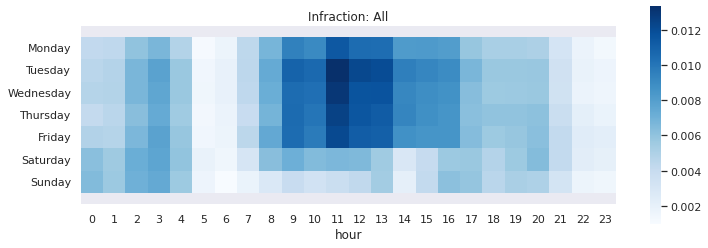

In [28]:
infraction = 'All'
plot_heatmap(infraction)

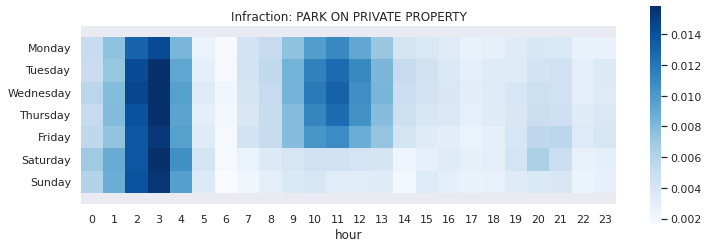

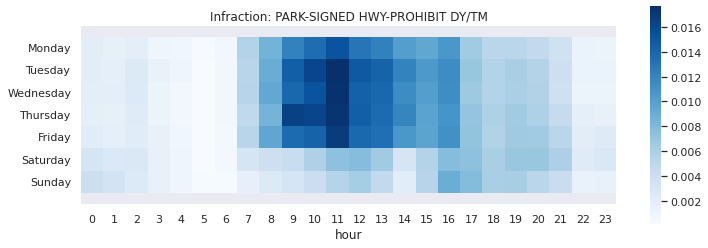

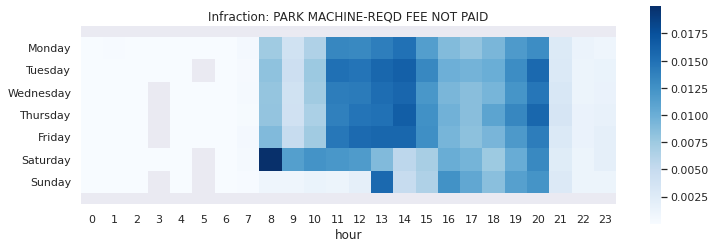

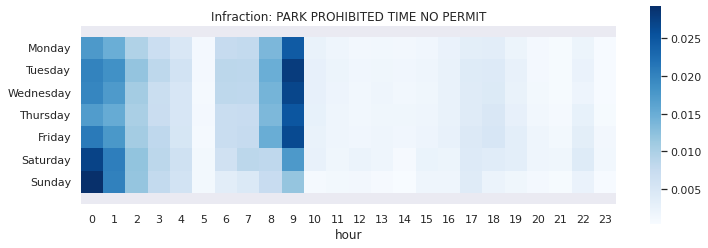

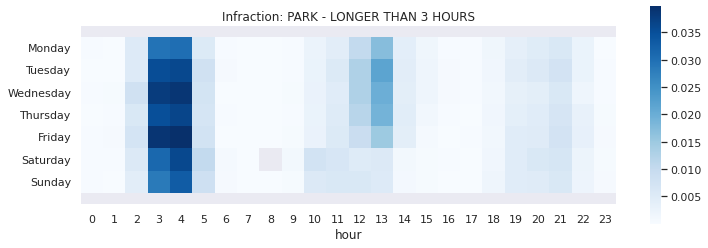

In [12]:
for infraction in df['infraction'].value_counts().head(5).index.values:
    plot_heatmap(infraction)

### Year exploration

* Aggregate tickets count everyday.
* We can clearly see the covid impact after 2020.
* Let's focus on 2019 only. 
* The decomposition plot shows the trend is lower in winter (late December and before March). 
* There is also a strong week cycle (seasonality in the plot) showing the count is lower on weekends.  
* Some residual outliers are due to holidays (like Easter, Victoria Day, Canada day, etc).

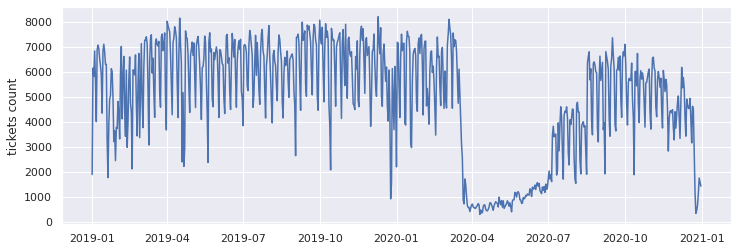

In [29]:
agg_df = df.groupby(pd.Grouper(key="date", freq='1D')).agg({'date':'count'}).rename({'date':'count'},axis=1) 

plt.figure(figsize=(12,4))
plt.plot(agg_df)
plt.ylabel('tickets count')
plt.show()

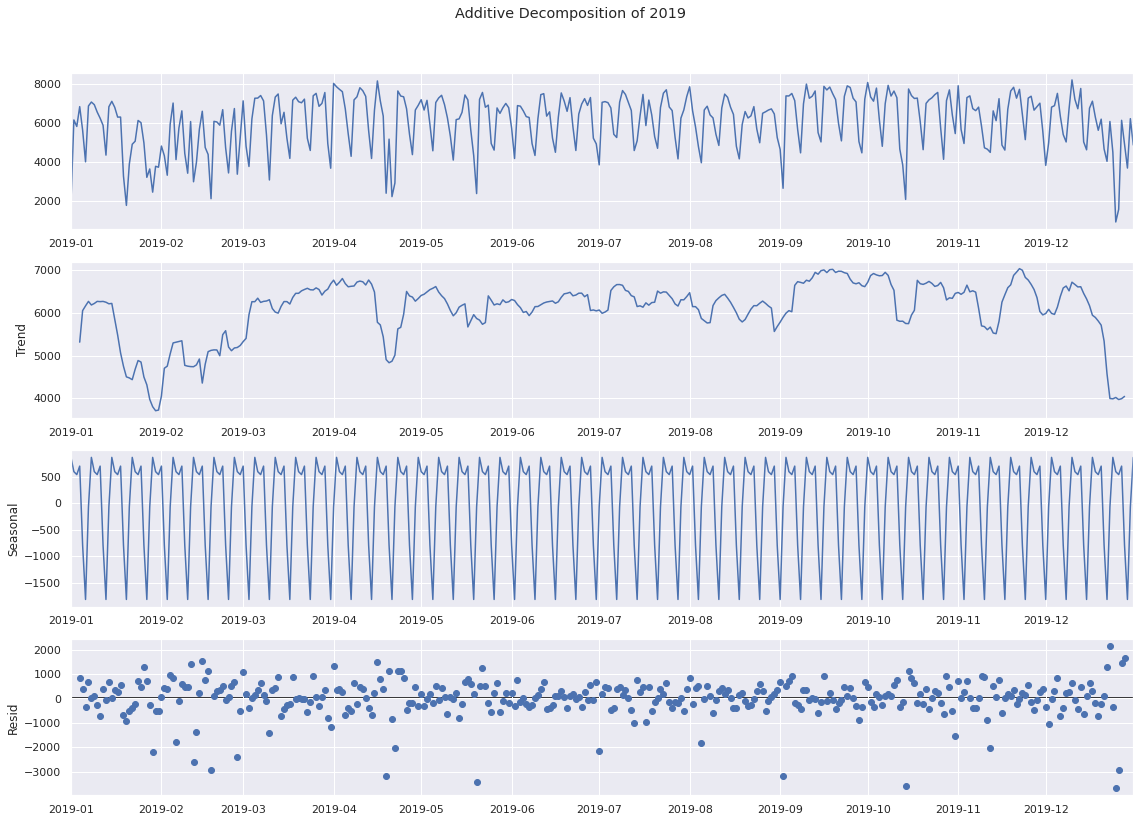

In [31]:
val = agg_df.loc[agg_df.index<'2020-01-01']
add_decomposition = seasonal_decompose(val, model='additive')
add_decomposition.plot().suptitle('Additive Decomposition of 2019')
plt.rcParams.update({'figure.figsize': (16,12)})
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Breakdown to top infractions

* If we breakdown the 2019 data to top 5 infraction types, there is no clear interesting patterned found.
* Basically, they all follow: the weekly cycle, lower in winter, some exceptions for holidays.
* If we normalize the tickets number and plot top 5 infraction types together, we can see these patterns:

Holidays and extreme weather days impact 'PARK - LONGER THAN 3 HOURS' and 'PARK MACHINE-REQD FEE NOT PAID' a lot. On those days, the city normally won't give you tickets because of not paying the machines or park longer.

'PARK-SIGNED HWY-PROHIBIT DY/TM' have several periodical peaks. This implies the city may issue those tickets in batches or the city has periodical enhanced inspections on the infraction.

In [30]:
def plot_decompose(infraction):
    infraction_df = df[(df['date']<'2020-01-01') & (df['infraction']==infraction)]
    agg_df = infraction_df.groupby(pd.Grouper(key="date", freq='1D')).agg({'date':'count'}).rename({'date':'count'},axis=1) 
    add_decomposition = seasonal_decompose(agg_df, model='additive')
    add_decomposition.plot().suptitle(f'Additive Decomposition of 2019 Infraction: {infraction}')
    plt.rcParams.update({'figure.figsize': (16,12)})
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

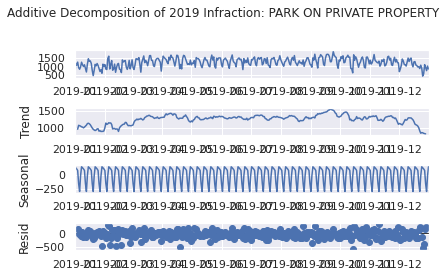

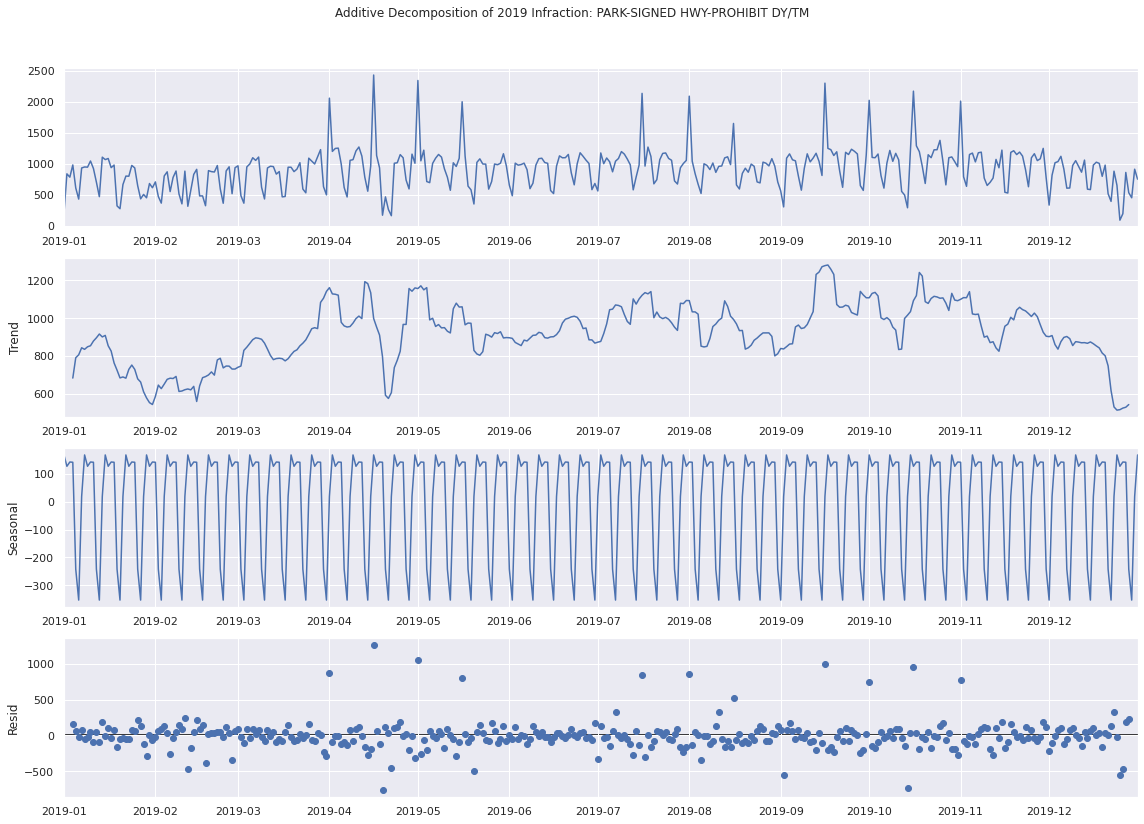

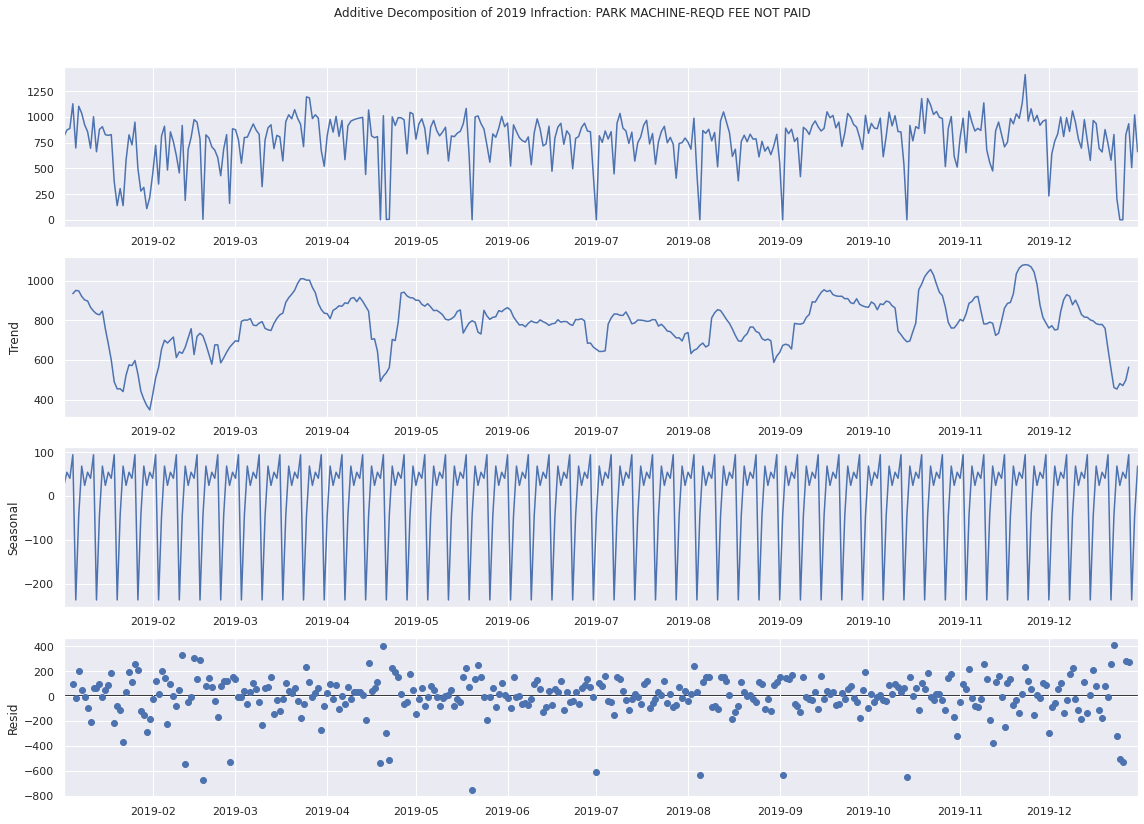

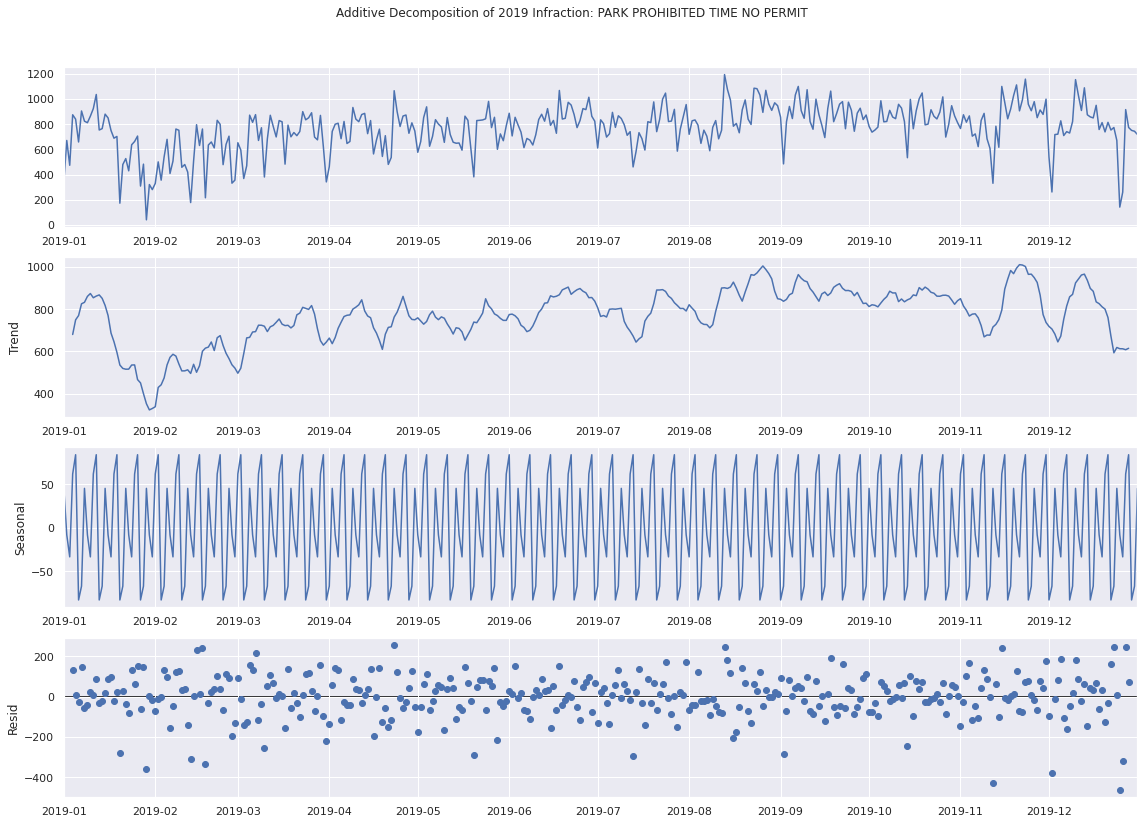

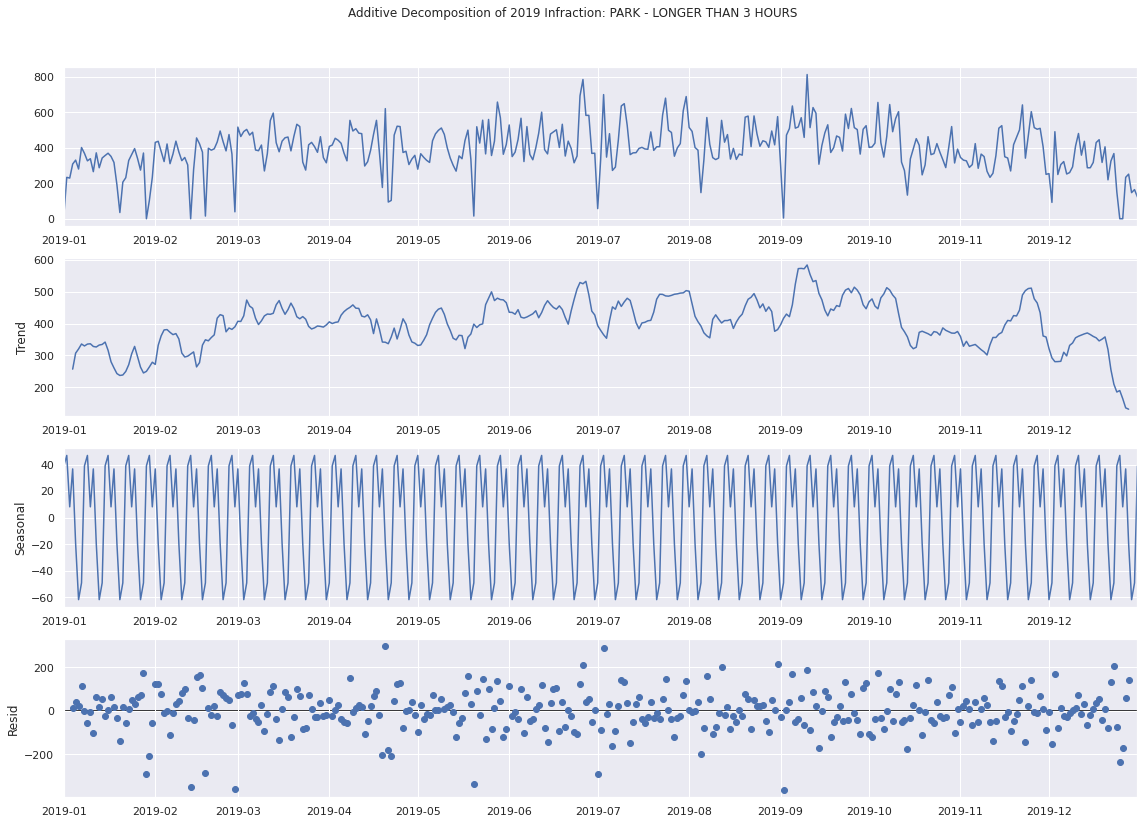

In [31]:
for infraction in df['infraction'].value_counts().head(5).index.values:
    plot_decompose(infraction)

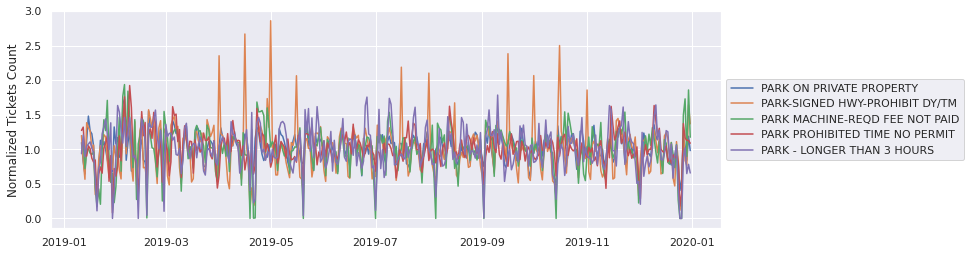

In [32]:
plt.figure(figsize=(12,4))

for infraction in df['infraction'].value_counts().head(5).index.values:
    infraction_df = df[(df['date']<'2020-01-01') & (df['infraction']==infraction)]
    agg_df = infraction_df.groupby(pd.Grouper(key="date", freq='1D')).agg({'date':'count'}).rename({'date':'count'},axis=1) 
    agg_df['count'] = agg_df['count']/agg_df['count'].rolling(10).mean().shift(1)
    plt.plot(agg_df, label=infraction)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Normalized Tickets Count')
plt.show()

## Exploration from location(map) perspective

### Top streets and locations

* We need map data to extract more insights. 
* Right now we can only treat the location as string.
* We will see top 10 street and top 10 locations with the most tickets.
* Each top locations has unique patterns. For instance, the majority tickets of 2075 BAYVIEW AVE are Park for private property during 10 am to 2 pm.  

In [20]:
df['street'] = df['location2'].str.replace(r"\d+",'', regex=True)

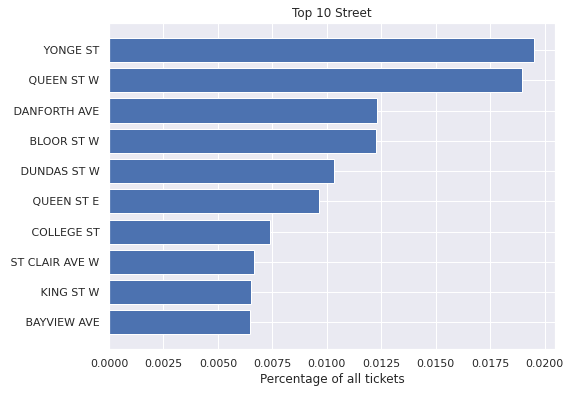

In [21]:
plot_df = df['street'].value_counts(normalize=True).head(10)[::-1]
plt.figure(figsize=(8,6))
plt.barh(plot_df.index, plot_df.values)
plt.xlabel('Percentage of all tickets')
plt.title('Top 10 Street')
plt.show()

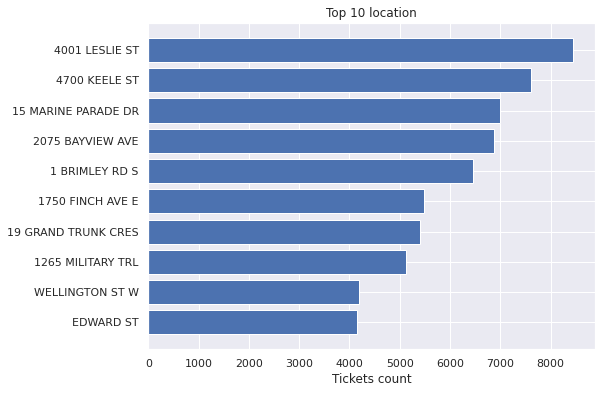

In [315]:
plot_df = df['location2'].value_counts().head(10)[::-1]
plt.figure(figsize=(8,6))
plt.barh(plot_df.index, plot_df.values)
plt.xlabel('Tickets count')
plt.title('Top 10 location')
plt.show()

In [22]:
def plot_location(location):
    agg_df = df[df['location2']==location].groupby(['infraction','hour','dayofweek'])['location2'].size()
    agg_df = agg_df.reset_index().rename({'location2':'count'},axis=1)
    p = alt.Chart(agg_df).mark_circle().encode(
        alt.X('hour',),
        alt.Y('dayofweek', ),
        color='infraction',
        size='count',    
    ).properties(
        title=f'{location}'
    ).configure_title(fontSize=24)
    p.display()

In [23]:
for loc in df['location2'].value_counts().head(10).index:
    plot_location(loc)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## What's the probability getting a ticket?

In [9]:
df['location2'].value_counts().head(10)

4001 LESLIE ST         8456
4700 KEELE ST          7615
15 MARINE PARADE DR    7000
2075 BAYVIEW AVE       6870
1 BRIMLEY RD S         6456
1750 FINCH AVE E       5482
19 GRAND TRUNK CRES    5397
1265 MILITARY TRL      5130
WELLINGTON ST W        4183
EDWARD ST              4157
Name: location2, dtype: int64

In [10]:
location = '4001 LESLIE ST'
target_df = df[(df['date']<'2020-01-01') & (df['location2']==location)].copy()

In [11]:
target_df['hour'] = target_df['date'].dt.hour
target_df['dayofweek'] = target_df['date'].dt.day_name()
target_df['dayofyear'] = target_df['date'].dt.dayofyear

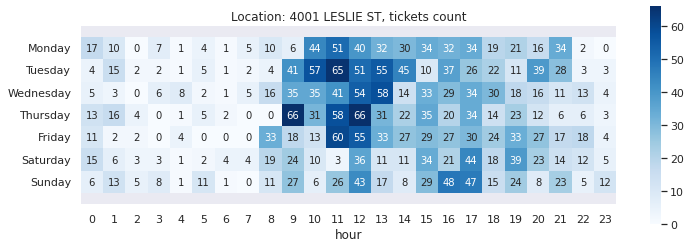

In [24]:
agg_df= target_df.groupby(['dayofweek','hour'])['dayofyear'].size()

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prob_ab = pd.pivot(agg_df.reset_index(), index='hour',columns='dayofweek')
prob_ab.columns = ([x[1] for x in prob_ab.columns])
prob_ab = prob_ab.T.reindex(cats)

plt.figure(figsize=(12,4))
ax = sns.heatmap(prob_ab.fillna(0), annot=True, fmt='.0f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, tickets count')
plt.show()

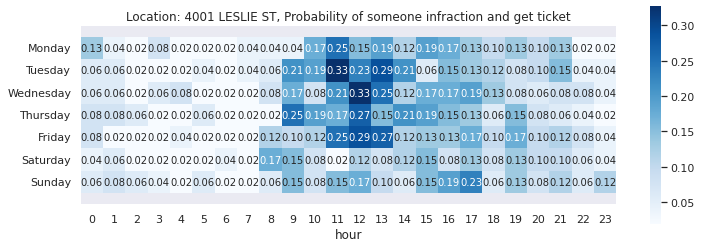

In [195]:
agg_df= target_df.groupby(['dayofweek','hour'])['dayofyear'].nunique()/52

cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
prob_ab = pd.pivot(agg_df.reset_index(), index='hour',columns='dayofweek')
prob_ab.columns = ([x[1] for x in prob_ab.columns])
prob_ab = prob_ab.T.reindex(cats).fillna(0.02)

plt.figure(figsize=(12,4))
ax = sns.heatmap(prob_ab, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, Probability of someone infraction and get ticket')
plt.show()

In [196]:
test = prob_ab.copy()
test[-1] = test[23]
test[24] = test[0]

test = test.T.sort_index()
for col in test.columns:
    test[col] = test[col].rolling(3).mean().shift(-1)
test = test.drop([-1,24])
prob_ab = test.T.reindex(cats)

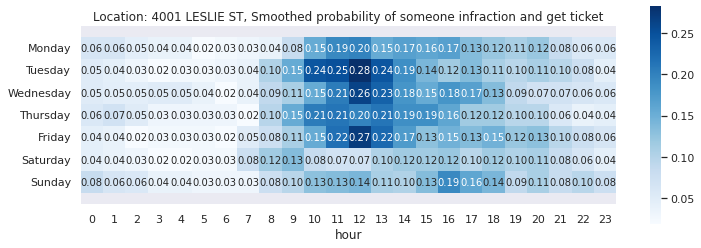

In [198]:
plt.figure(figsize=(12,4))
ax = sns.heatmap(prob_ab, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, Smoothed probability of someone infraction and get ticket')
plt.show()

In [107]:
(170132+118152)/365

789.8191780821918

In [ ]:
600, 250, 250

In [189]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visitors_df = prob_ab.copy()

In [190]:
hour_visits = {0:2,1:1,2:1,3:1,4:1,5:1,6:1,7:2,8:4,9:5,10:6,11:7,12:7,
               13:7,14:7,15:7,16:6,17:5,18:5,19:4,20:4,21:3,22:3,23:2}

for k,v in hour_visits.items():
    visitors_df[k] = v*3
    
for col in [9,10,11,12,13,14,15,16,17]:
    visitors_df.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],col] += 40   

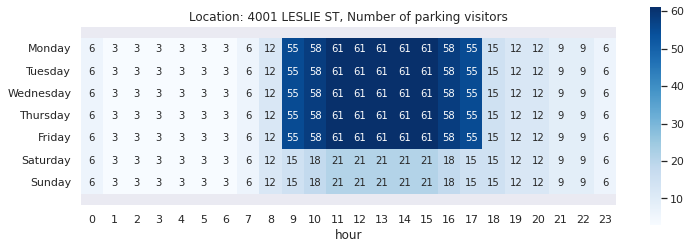

In [179]:
plt.figure(figsize=(12,4))
ax = sns.heatmap(visitors_df, annot=True, fmt='.0f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, Number of parking visitors')
plt.show()

In [180]:
visitors_df.sum(axis=1)

Monday       636
Tuesday      636
Wednesday    636
Thursday     636
Friday       636
Saturday     276
Sunday       276
dtype: int64

In [192]:
prob_b = pd.DataFrame((1-(1-0.005)**visitors_df.values),index=cats)

In [214]:
(prob_b - prob_ab).sum().sum()

0.1087206845083677

In [234]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', 0, 0.1)    
    prob_b = pd.DataFrame((1-(1-x)**visitors_df.values),index=cats)
    # a = (prob_b - prob_ab).sum().sum()
    a = (prob_b - prob_ab)
    a[(a<0)]=0.5
    return a.sum().sum()    

In [238]:
# study = optuna.create_study()
# study.optimize(objective, n_trials=200)
# study.best_params 

In [242]:
(0.633045)**6

0.0643587347562287

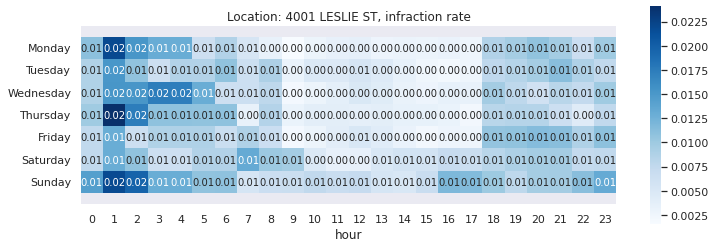

In [246]:
rate_df = 1- (1-prob_ab)**(1/visitors_df.values)

plt.figure(figsize=(12,4))
ax = sns.heatmap(rate_df, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, infraction rate')
plt.show()

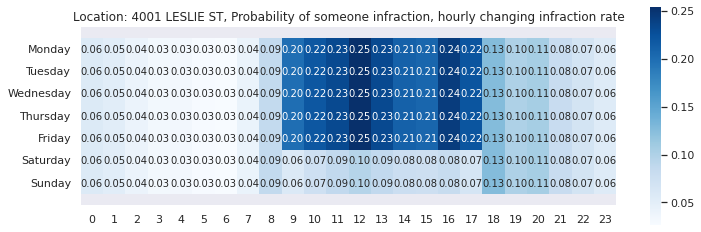

In [254]:
rate = rate_df.mean()
prob_b = pd.DataFrame()
for idx,val in rate.iteritems():    
    prob_b.loc[:,idx] = (1-(1-val)**visitors_df[idx].values)
    
prob_b.index = cats
plt.figure(figsize=(12,4))
ax = sns.heatmap(prob_b, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, Probability of someone infraction, hourly changing infraction rate')
plt.show()

$P(Inspection   AND  Infraction) = P(Inspection|Infraction) * P(Infraction)$

$ 1 - (1-infractionrate**(numberofvisitor))$

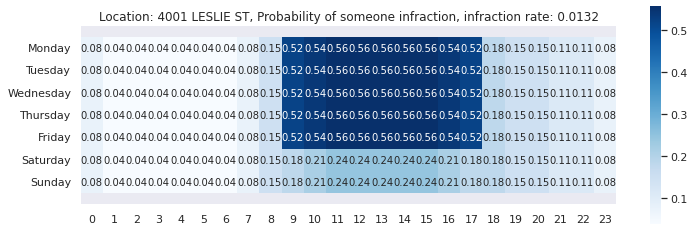

In [239]:
x =  0.0132

prob_b = pd.DataFrame((1-(1-x)**visitors_df.values),index=cats)

plt.figure(figsize=(12,4))
ax = sns.heatmap(prob_b, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, Probability of someone infraction, infraction rate: {x}')
plt.show()

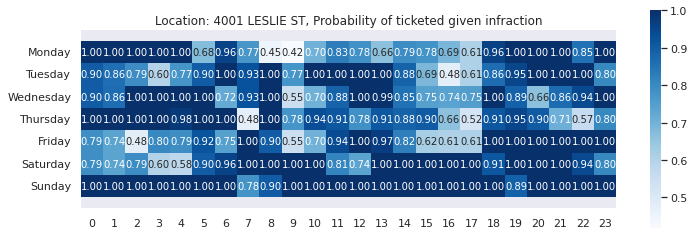

In [255]:
prob_a = pd.DataFrame(np.clip(prob_ab.fillna(0).values/prob_b.values,0,1),index=cats)

plt.figure(figsize=(12,4))
ax = sns.heatmap(prob_a, annot=True, fmt='.2f', cmap='Blues', cbar=True, linewidths=0,square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title(f'Location: {location}, Probability of ticketed given infraction')
plt.show()

### Association rules mining

* We can some strong associations for locations, for instance:

If the ticket is "PARK COMMERC LOAD ZONE NOT LDG", then it's likely it happened on YORKVILLE AVE.

If the ticket is "STAND VEH.-PSGR LD ZN LD/UNLD", then it's likely it happened on BLOOR ST W. 

In [24]:
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import OneHotEncoder

In [25]:
cols = ['infraction','hour','dayofweek','street']
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

encoded_df = pd.DataFrame(enc.fit_transform(df[df['street'].isin(df['street'].value_counts().index.values[:20])][cols]),columns=enc.get_feature_names(cols))

for col in encoded_df.columns.tolist():
    encoded_df[col] = encoded_df[col].astype(bool)
    
encoded_df.shape 

(588838, 190)

In [26]:
#setting max_len to the level you are interested in
f_itemsets = apriori(encoded_df.dropna(), min_support=0.005, use_colnames=True, max_len=2)
f_itemsets.shape

(432, 2)

In [27]:
rules = association_rules(f_itemsets, metric="confidence", min_threshold=0.3,)

rules['antecedents'] = rules['antecedents'].apply(lambda x: ','.join(x))
rules['consequents'] = rules['consequents'].apply(lambda x: ','.join(x))

print(rules.shape)

(44, 9)


In [28]:
rules = rules[rules['consequents'].str.slice(0,1)>rules['antecedents'].str.slice(0,1)]
rules[(rules['consequents'].str.contains('street_')) | (rules['antecedents'].str.contains('street_'))].sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,infraction_PARK COMMERC LOAD ZONE NOT LDG,street_ YORKVILLE AVE,0.026240,0.030757,0.013313,0.507346,16.495196,0.012506,1.967390
38,infraction_STAND VEH.-PSGR LD ZN LD/UNLD,street_ BLOOR ST W,0.006481,0.075173,0.006245,0.963574,12.818011,0.005757,25.389482
43,hour_21,street_ YONGE ST,0.031503,0.119743,0.009787,0.310674,2.594514,0.006015,1.276982
